In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import time

from Model import ColorModel

import tensorflow as tf
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')

# This suppress future warning of tensorflow
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Without these lines, bert will error out with : Blas GEMM launch failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"

In [4]:
def get_image(file_path):
    
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = img / 255
    
    return img


def train_model(epochs, optimizer, train_dataset, valid_dataset, loss_fn, loss_metric, 
                save_path='models', 
                batch_size=16,
                save_iter_num=10, 
                ver_iter_num=10):
    
    
    # Loss values for plotting
    train_loss_values = []
    
    epoch = 1
    
    prev_loss = 0 
    spent_time = 0
    
    steps = tf.data.experimental.cardinality(train_ds).numpy() // batch_size
    
    start = time.time()
    
    while epoch < (epochs+1):
        
        # Iterate over the batches of the dataset.
        for step, rgb_images in enumerate(train_dataset):

            with tf.GradientTape() as tape:

                # Convert to Images
                # Create grayscale images for y
                gray_images = tf.image.rgb_to_grayscale(rgb_images)

                pred_images = model(gray_images)

                loss = loss_fn(rgb_images, pred_images)

                loss += sum(model.losses)
                

            grads = tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(grads, model.trainable_weights))

            loss_metric(loss)

            loss_result = loss_metric.result()

            train_loss_values.append(loss_result)

            if step >= steps:
                break

                
        if epoch % ver_iter_num == 0:

            print(f'Epoch : {epoch}, Loss : {loss_result}, It took {round(time.time() - start, 3)} secs')
            
            with open('plots/losses.txt', 'a') as file:
                file.writelines(str(loss_result.numpy()) + '\n')
        
            start = time.time()

            
        if epoch % save_iter_num == 0:
            
            total_loss = 0
            
            for rgb_images in valid_dataset:
                
                gray = tf.image.rgb_to_grayscale(rgb_images)
                pred = model(gray)
                loss = loss_fn(rgb_images, pred)
                loss += sum(model.losses)
                
                loss_metric(loss)
                loss_result = loss_metric.result()
                total_loss += loss_result
                
            with open('plots/valid_losses.txt', 'a') as file:
                file.writelines(str(total_loss.numpy()) + '\n')
                
            
            print('\nSaving model\n')
            model.save_weights(f'{save_path}/model.ckpt')
            
            
        if epoch % 1000 == 0:
            
            try:
                for i in valid_dataset.take(1):
                    img = i[:1]

                    pred = tf.image.rgb_to_grayscale(img)
                    pred = model(pred)
                    pred = pred.numpy()

                fig, ax = plt.subplots(1, 3, figsize=(20, 12))

                ax[0].imshow(cv2.cvtColor(img.numpy()[0], cv2.COLOR_RGB2GRAY), cmap='gray')
                ax[1].imshow(pred[0])
                ax[2].imshow(img.numpy()[0])

                ax[0].set_title('Grayscale')
                ax[1].set_title('Pred RGB')
                ax[2].set_title('True RGB')

                fig.savefig(f'plots/Model_Epoch{epoch}.png')
            except:
                pass
            
        epoch += 1
            
    return train_loss_values

In [5]:
dataset = tf.data.Dataset.list_files('data/images/*.jpg')

train_ds = dataset.skip(200)
val_ds = dataset.take(200)

batch_size = 16

train_ds = train_ds.map(get_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size).shuffle(1)
valid_ds = val_ds.map(get_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size)

In [7]:
model = ColorModel((224,224, 3), 3, 2)

loss_fn = tf.keras.losses.MeanSquaredError()
# optimizer = tf.optimizers.SGD(learning_rate=1e-7, momentum=.3, decay=.99)
optimizer= tf.optimizers.Adam(1e-4, amsgrad=True)
loss_metric = tf.keras.metrics.Mean()

h = train_model(50000, optimizer, train_ds, valid_ds, loss_fn, loss_metric, batch_size=batch_size, ver_iter_num=1, save_iter_num=50)

<Figure size 576x576 with 0 Axes>

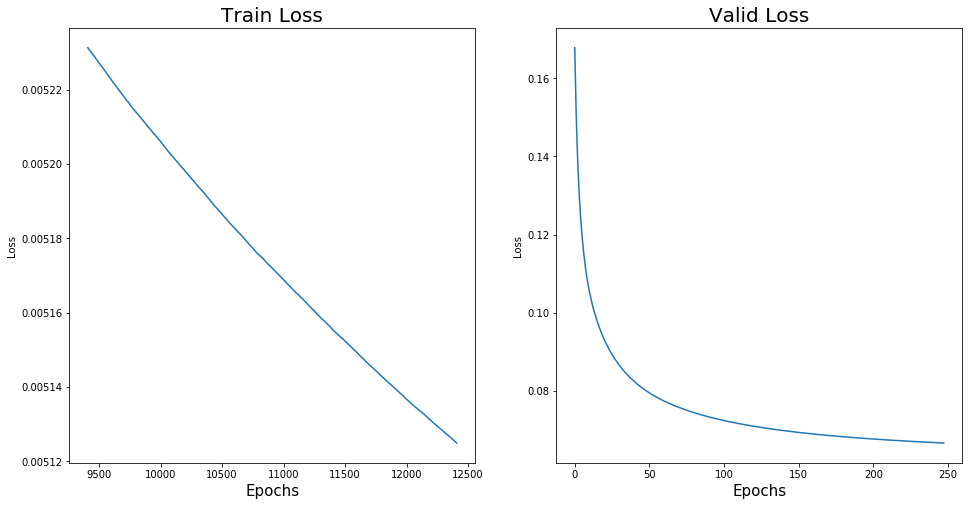

In [161]:
with open('plots/losses.txt', 'r') as file:
    loss = file.readlines()
    loss = pd.Series(loss)
    loss = loss.str.replace("\n", '')
    loss = loss.astype('float32')
    
with open('plots/valid_losses.txt', 'r') as file:
    val_loss = file.readlines()
    val_loss = pd.Series(val_loss)
    val_loss = val_loss.str.replace("\n", '')
    val_loss = val_loss.astype('float32')
    
plt.figure(figsize=(8, 8))

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].plot(loss[-3000:], label='Train Loss')
ax[0].set_title('Train Loss', size=20)
ax[0].set_xlabel('Epochs', size=15)
ax[0].set_ylabel('Loss')

ax[1].plot(val_loss, label='Valid Loss')
ax[1].set_title('Valid Loss', size=20)
ax[1].set_xlabel('Epochs', size=15)
ax[1].set_ylabel('Loss')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


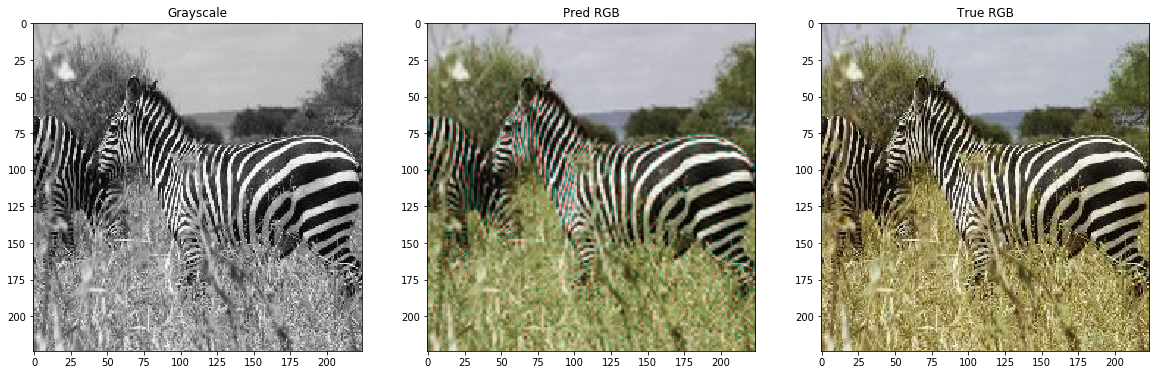

In [165]:
z = ColorModel((224, 224, 3),3,2)
z.load_weights('models/model.ckpt')

for i in train_ds.take(1):
    img = i[:1]
    
    pred = tf.image.rgb_to_grayscale(img)
    pred = z(pred)
    pred = pred.numpy()
    
fig, ax = plt.subplots(1, 3, figsize=(20, 12))

ax[0].imshow(cv2.cvtColor(img.numpy()[0], cv2.COLOR_RGB2GRAY), cmap='gray')
ax[1].imshow(pred[0])
ax[2].imshow(img.numpy()[0])

ax[0].set_title('Grayscale')
ax[1].set_title('Pred RGB')
ax[2].set_title('True RGB')

plt.show()

# fig.savefig('plots/Model3_Epoch3000.png')